Install all the things.

In [9]:
!pip install shapely
!conda install --yes --quiet fiona
!pip install fiona
!pip install gbdxtools

  Using cached Shapely-1.5.17.post1-cp27-cp27m-macosx_10_6_intel.whl


And then all the imports and such.

In [3]:
from shapely.geometry import shape
from gbdxtools import Interface
from shapely.geometry import MultiPolygon
from shapely.wkt import loads
from shapely.ops import cascaded_union
import dateutil.parser
from datetime import datetime
import uuid
from os.path import join
import time
import sys
from __future__ import print_function
import fiona
import json

Load the shapefile, get one of the polygons, and convert to shape.

In [4]:
c = fiona.open('/Users/chambbj/Downloads/(U) Harbors_Beachfront_Apr2017/Harbors_Priority_Beachfront.shp')
pol = next(iter(c))
geom = shape(pol['geometry'])
geom

Create our GBDX interface.

In [8]:
gbdx = Interface()

Create a multipolygon of all the polys, but I don't appear to actually use this anywhere.

In [9]:
Multi = MultiPolygon([shape(pol['geometry']) for pol in c])

Show that we can get the WKT of the geometry.

In [10]:
geom.wkt

'POLYGON ((-17.46872999999994 14.63327000000004, -17.47172999999998 14.63327000000004, -17.47172999999998 14.63787000000008, -17.47172999999998 14.64397000000002, -17.47172999999998 14.64727000000005, -17.47172999999998 14.65127000000007, -17.47172999999998 14.65717000000006, -17.47172999999998 14.66507000000007, -17.47172999999998 14.67297000000008, -17.47172999999998 14.67727000000002, -17.47172999999998 14.68277000000006, -17.47172999999998 14.68637000000007, -17.47172999999998 14.69277000000005, -17.47172999999998 14.69727000000006, -17.47172999999998 14.70117000000005, -17.47172999999998 14.71527000000003, -17.47172999999998 14.72657000000004, -17.47172999999998 14.73217000000005, -17.47172999999998 14.73957000000007, -17.47172999999998 14.74497000000002, -17.47172999999998 14.74997000000008, -17.30002999999994 14.74997000000008, -17.30002999999994 14.74107000000004, -17.30002999999994 14.73057000000006, -17.30002999999994 14.71867000000003, -17.30002999999994 14.71227000000005, -

Create a filter (WV2 with cloud cover less than 10%), and search the catalog.

In [11]:
filters = ["sensorPlatformName='WORLDVIEW02'","cloudCover<10"]
results = gbdx.catalog.search(searchAreaWkt=geom.wkt,filters=filters)
len(results)

Show that we can get the footprint WKT of the first result.

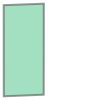

In [13]:
footprint = loads(results[1]['properties']['footprintWkt'])
footprint

Get a sense for how the footprint overlaps the query geometry. A percent overlap would be nice too.

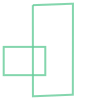

In [14]:
geom.boundary.union(footprint.boundary)

And just look at the acquisition metadata for the result.

In [16]:
results[1]

{u'identifier': u'103001000347F400',
 u'properties': {u'browseURL': u'https://geobigdata.io/thumbnails/v1/browse/103001000347F400.large.png',
  u'catalogID': u'103001000347F400',
  u'cloudCover': 6,
  u'footprintWkt': u'MULTIPOLYGON(((-17.3514312 14.92230171, -17.18582416 14.92829376, -17.18585252 14.88465988, -17.18588241 14.84102102, -17.18590026 14.79735758, -17.18592754 14.75369113, -17.18604233 14.70999666, -17.18613234 14.66630565, -17.1861788 14.62262483, -17.18621993 14.57894497, -17.18625175 14.55255822, -17.35104628 14.5459354, -17.3510685 14.57226729, -17.35111791 14.6160304, -17.35116979 14.65979396, -17.35121525 14.70355694, -17.35122556 14.74732731, -17.35126496 14.79108787, -17.35131674 14.83484626, -17.35136975 14.87857729, -17.3514312 14.92230171)))',
  u'imageBands': u'PAN_MS1_MS2',
  u'multiResolution': 1.97392213344574,
  u'multiResolution_end': 1.97252249717712,
  u'multiResolution_max': 1.97512292861938,
  u'multiResolution_min': 1.97252249717712,
  u'multiResolut

Okay, now we actually get into creating and executing workflows. Here we will start by getting the lat/lon of the footprint centroid, and also the timestamp to be used in predicting tides. We continue by creating a workflow that automatically orders the data, applies atmospheric compensation via AOP, and the performs shoreline detection. We make sure to save the outputs of the final task.

In [131]:
cat_id = results[1]['identifier']
record = gbdx.catalog.get(cat_id)
centroid = loads(record.get('properties').get('footprintWkt')).centroid
lat = centroid.y
lon = centroid.x
print('lat=%f, lon=%f' % (lat, lon))
timestamp = dateutil.parser.parse(record.get('properties').get('timestamp'))
dtg = datetime.strftime(timestamp, '%Y-%m-%d-%H-%M')
print('dtg="%s"' % dtg)
print('lat="%s", lon="%s", dtg="%s"' % (str(lat), str(lon), dtg))
ordertask = gbdx.Task('Auto_Ordering', cat_id=cat_id)
ordertask.impersonation_allowed = True

aoptask = gbdx.Task('AOP_Strip_Processor',
                 data=ordertask.outputs.s3_location.value,
                 bands='MS',
                 enable_dra=False,
                 enable_pansharpen=False,
                 enable_acomp=True,
                 ortho_epsg='UTM')

tide_task = gbdx.Task('ShorelineDetection_beta',
                      lat = str(lat),
                      lon = str(lon),
                      dtg = dtg,
                      meta = json.dumps(results[1]),
                      image = aoptask.outputs.data.value)

workflow = gbdx.Workflow([ordertask, aoptask, tide_task])
random_str = str(uuid.uuid4())
workflow.savedata(tide_task.outputs.results, location=join('some_random_folder', random_str))

lat=14.737430, lon=-17.268643
dtg="2009-12-11-11-41"
lat="14.7374302272", lon="-17.2686430881", dtg="2009-12-11-11-41"


Execute the workflow.

In [133]:
workflow.execute()

u'4649123387300274527'

And view the definition for kicks.

In [135]:
workflow.definition

{'name': u'63ed74ce',
 'tasks': [{'containerDescriptors': [{'properties': {'domain': 'default'}}],
   'impersonation_allowed': True,
   'inputs': [{'name': u'cat_id', 'value': u'103001000347F400'}],
   'name': u'Auto_Ordering_b8979ccd',
   'outputs': [{'name': u's3_location'}],
   'taskType': 'Auto_Ordering',
   'timeout': 172800},
  {'containerDescriptors': [{'properties': {'domain': u'raid'}}],
   'inputs': [{'name': u'enable_dra', 'value': 'false'},
    {'name': u'bands', 'value': 'MS'},
    {'name': u'enable_acomp', 'value': 'true'},
    {'name': u'ortho_epsg', 'value': 'UTM'},
    {'name': u'enable_pansharpen', 'value': 'false'},
    {'name': u'data', 'source': u'Auto_Ordering_b8979ccd:s3_location'}],
   'name': u'AOP_Strip_Processor_8586300d',
   'outputs': [{'name': u'data'}, {'name': u'log'}],
   'taskType': 'AOP_Strip_Processor',
   'timeout': 36000},
  {'containerDescriptors': [{'properties': {'domain': 'default'}}],
   'inputs': [{'name': u'lon', 'value': '-17.2686430881'},


We can loop until the workflow shows up as complete.

In [ ]:
while not workflow.status.get('state') == u'complete':
    print(json.dumps(workflow.events), end='\r')
#     print(datetime.now(), workflow.status, end='\r')
    sys.stdout.flush()
    time.sleep(5.0)
workflow.status

Download the shoreline result.

In [117]:
gbdx.s3.download(join('some_random_folder', random_str))

This notebook needs lots of cleaning up. The following chunk will be used to run only ACOMP, such that we can test this workflow locally too.

In [118]:
cat_id = results[1]['identifier']
record = gbdx.catalog.get(cat_id)
centroid = loads(record.get('properties').get('footprintWkt')).centroid
lat = centroid.y
lon = centroid.x
print('lat=%f, lon=%f' % (lat, lon))
timestamp = dateutil.parser.parse(record.get('properties').get('timestamp'))
dtg = datetime.strftime(timestamp, '%Y-%m-%d-%H-%M')
print('dtg="%s"' % dtg)
print('lat="%s", lon="%s", dtg="%s"' % (str(lat), str(lon), dtg))
ordertask = gbdx.Task('Auto_Ordering', cat_id=cat_id)
ordertask.impersonation_allowed = True

aoptask = gbdx.Task('AOP_Strip_Processor',
                 data=ordertask.outputs.s3_location.value,
                 bands='MS',
                 enable_dra=False,
                 enable_pansharpen=False,
                 enable_acomp=True,
                 ortho_epsg='UTM')

workflow = gbdx.Workflow([ordertask, aoptask])
random_str = str(uuid.uuid4())
print(random_str)
workflow.savedata(aoptask.outputs.data, location=join('acomp-only-testing', random_str))

lat=14.737430, lon=-17.268643
dtg="2009-12-11-11-41"
lat="14.7374302272", lon="-17.2686430881", dtg="2009-12-11-11-41"
6fe837c1-dd7d-442c-abda-aa9edbe93c8c


Execute the ACOMP.

In [120]:
workflow.execute()
while not workflow.status.get('state') == u'complete':
    print(json.dumps(workflow.events), end='\r')
#     print(datetime.now(), workflow.status, end='\r')
    sys.stdout.flush()
    time.sleep(5.0)
workflow.status

{u'event': u'succeeded', u'state': u'complete'}

Grab the URL of the ACOMP raster output.

In [126]:
aopraster = 's3://gbd-customer-data/a6308131-a55f-4f07-a436-68502f273a9f/acomp-only-testing/6fe837c1-dd7d-442c-abda-aa9edbe93c8c/'

Now execute a workflow that cuts out auto order and AOP steps, using precomputed result.

In [137]:
cat_id = results[1]['identifier']
record = gbdx.catalog.get(cat_id)
centroid = loads(record.get('properties').get('footprintWkt')).centroid
lat = centroid.y
lon = centroid.x
print('lat=%f, lon=%f' % (lat, lon))
timestamp = dateutil.parser.parse(record.get('properties').get('timestamp'))
dtg = datetime.strftime(timestamp, '%Y-%m-%d-%H-%M')
print('dtg="%s"' % dtg)
print('lat="%s", lon="%s", dtg="%s"' % (str(lat), str(lon), dtg))

tide_task = gbdx.Task('ShorelineDetection_beta',
                      lat = str(lat),
                      lon = str(lon),
                      dtg = dtg,
                      meta = json.dumps(results[1]),
                      minsize = '1000.0',
                      smooth = '0.8',
                      image = aopraster)

workflow = gbdx.Workflow([tide_task])
random_str = str(uuid.uuid4())
workflow.savedata(tide_task.outputs.vector, location=join('shoreline-tests', random_str))

lat=14.737430, lon=-17.268643
dtg="2009-12-11-11-41"
lat="14.7374302272", lon="-17.2686430881", dtg="2009-12-11-11-41"


Execute.

In [138]:
workflow.execute()
while not workflow.status.get('state') == u'complete':
    print(json.dumps(workflow.events), end='\r')
#     print(datetime.now(), workflow.status, end='\r')
    sys.stdout.flush()
    time.sleep(5.0)
workflow.status

{u'event': u'succeeded', u'state': u'complete'}

for AF test

In [142]:
ordertask = gbdx.Task('Auto_Ordering', cat_id=cat_id)
ordertask.impersonation_allowed = True

aoptask = gbdx.Task('AOP_Strip_Processor',
                 data=ordertask.outputs.s3_location.value,
                 bands='MS',
                 enable_dra=False,
                 enable_pansharpen=False,
                 enable_acomp=True,
                 ortho_epsg='UTM')

tide_task = gbdx.Task('ShorelineDetection_beta',
                      lat = str(lat),
                      lon = str(lon),
                      dtg = dtg,
                      meta = json.dumps(results[1]),
                      image = aoptask.outputs.data.value)

workflow = gbdx.Workflow([ordertask, aoptask, tide_task])
random_str = str(uuid.uuid4())
workflow.savedata(tide_task.outputs.vector, location=join('some_random_folder', random_str))
workflow.execute()

u'4649159657153601513'